C:\Users\serhan\AppData\Local\Temp\ipykernel_18020\2303186606.py:70: DtypeWarning:

Columns (113) have mixed types. Specify dtype option on import or set low_memory=False.



  provincia provincia_nome
0       084      Agrigento
1       084      Agrigento
2       084      Agrigento
3       084      Agrigento
4       084      Agrigento
day_night
1    112098
0     51657
Name: count, dtype: int64

Fatalities by Day/Night:
day_night
0    0.021604
1    0.013265
Name: morti_entro_24_ore, dtype: float64


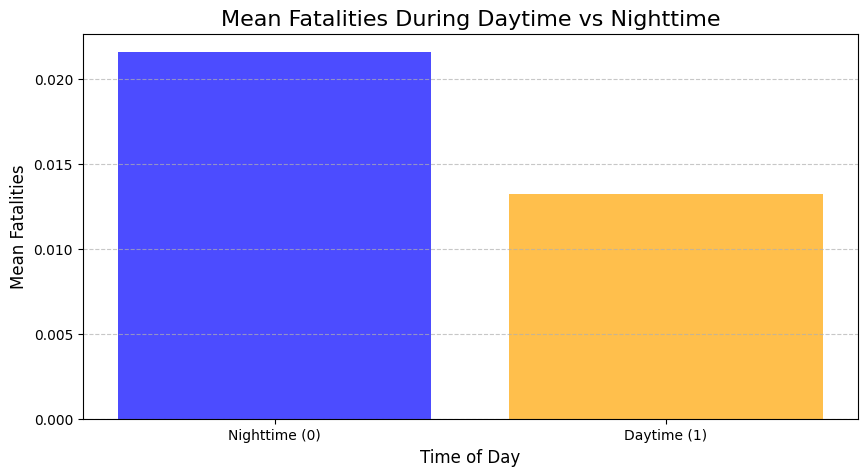

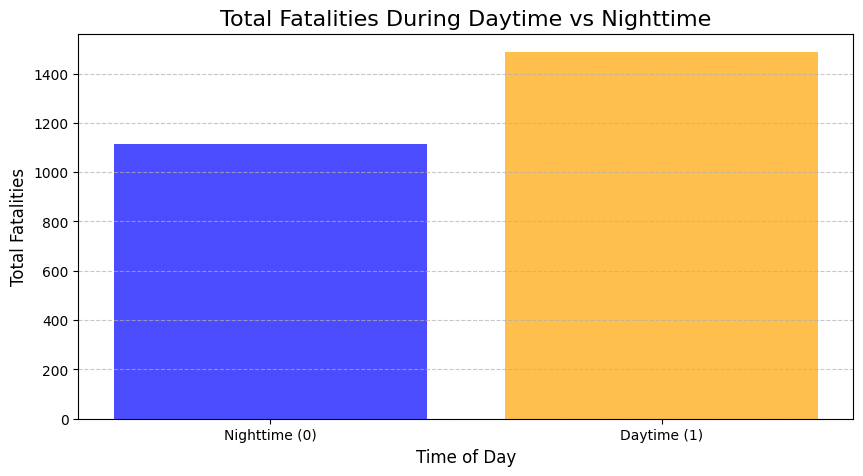

In [14]:
#!/usr/bin/env python
"""
This script performs an impact evaluation analysis on traffic accident data. The analysis includes:

1. Data Loading and Preprocessing:
    - Load the dataset from a specified file path.
    - Convert the 'Ora' column to numeric and handle errors.
    - Create a 'day_night' column to distinguish between daytime (7-19) and nighttime (19-7).
    - Filter the top 25 provinces with the most accidents.
    - Clean and preprocess age categories.
    - Encode categorical variables as dummies.

2. Exploratory Data Analysis:
    - Calculate and visualize mean and total fatalities during daytime vs nighttime.
    - Generate bar charts for mean and total fatalities.

3. Propensity Score Matching:
    - Estimate propensity scores using logistic regression.
    - Perform nearest-neighbor matching based on propensity scores.
    - Check balance before and after matching.
    - Estimate the Average Treatment Effect on the Treated (ATT).

4. Inverse Probability Weighting (IPW):
    - Calculate IPW weights.
    - Compute weighted means for the outcome.
    - Estimate ATT using IPW.
    - Visualize weighted propensity score distributions and weighted outcome means.

5. Data Saving:
    - Save the processed data and matched data to Excel files.

Modules used:
- pandas
- numpy
- matplotlib.pyplot
- seaborn
- sklearn.linear_model.LogisticRegression
- sklearn.neighbors.NearestNeighbors
- sklearn.metrics.pairwise_distances
- statsmodels.api

Functions:
- pd.read_csv: Load dataset.
- pd.to_numeric: Convert column to numeric.
- pd.get_dummies: Encode categorical variables.
- LogisticRegression: Estimate propensity scores.
- NearestNeighbors: Perform nearest-neighbor matching.
- sm.Logit: Fit logistic regression model.
- plt.bar, plt.hist, sns.kdeplot: Visualize data.
- pd.to_excel: Save data to Excel files.

"""
# coding: utf-8

# In[2]:


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from statsmodels.api import OLS, add_constant
import statsmodels.api as sm

# Load your dataset
file_path = r"D:\My lessons notes\2024\Impact Evaluation\MICRODATI\INCSTRAD_Microdati_2022.txt"
data= pd.read_csv(file_path, sep='\t')


province_mapping = {
    '001': 'Torino',
    '002': 'Vercelli',
    '003': 'Novara',
    '004': 'Cuneo',
    '005': 'Asti',
    '006': 'Alessandria',
    '007': "Valle d'Aosta/Vallee d Aoste",
    '008': 'Imperia',
    '009': 'Savona',
    '010': 'Genova',
    '011': 'La Spezia',
    '012': 'Varese',
    '013': 'Como',
    '014': 'Sondrio',
    '015': 'Milano',
    '016': 'Bergamo',
    '017': 'Brescia',
    '018': 'Pavia',
    '019': 'Cremona',
    '020': 'Mantova',
    '021': 'Bolzano/Bozen',
    '022': 'Trento',
    '023': 'Verona',
    '024': 'Vicenza',
    '025': 'Belluno',
    '026': 'Treviso',
    '027': 'Venezia',
    '028': 'Padova',
    '029': 'Rovigo',
    '030': 'Udine',
    '031': 'Gorizia',
    '032': 'Trieste',
    '033': 'Piacenza',
    '034': 'Parma',
    '035': "Reggio nell'Emilia",
    '036': 'Modena',
    '037': 'Bologna',
    '038': 'Ferrara',
    '039': 'Ravenna',
    '040': 'Forlì-Cesena',
    '041': 'Pesaro e Urbino',
    '042': 'Ancona',
    '043': 'Macerata',
    '044': 'Ascoli Piceno',
    '045': 'Massa-Carrara',
    '046': 'Lucca',
    '047': 'Pistoia',
    '048': 'Firenze',
    '049': 'Livorno',
    '050': 'Pisa',
    '051': 'Arezzo',
    '052': 'Siena',
    '053': 'Grosseto',
    '054': 'Perugia',
    '055': 'Terni',
    '056': 'Viterbo',
    '057': 'Rieti',
    '058': 'Roma',
    '059': 'Latina',
    '060': 'Frosinone',
    '061': 'Caserta',
    '062': 'Benevento',
    '063': 'Napoli',
    '064': 'Avellino',
    '065': 'Salerno',
    '066': "L'Aquila",
    '067': 'Teramo',
    '068': 'Pescara',
    '069': 'Chieti',
    '070': 'Campobasso',
    '071': 'Foggia',
    '072': 'Bari',
    '073': 'Taranto',
    '074': 'Brindisi',
    '075': 'Lecce',
    '076': 'Potenza',
    '077': 'Matera',
    '078': 'Cosenza',
    '079': 'Catanzaro',
    '080': 'Reggio Calabria',
    '081': 'Trapani',
    '082': 'Palermo',
    '083': 'Messina',
    '084': 'Agrigento',
    '085': 'Caltanissetta',
    '086': 'Enna',
    '087': 'Catania',
    '088': 'Ragusa',
    '089': 'Siracusa',
    '090': 'Sassari',
    '091': 'Nuoro',
    '092': 'Cagliari',
    '093': 'Pordenone',
    '094': 'Isernia',
    '095': 'Oristano',
    '096': 'Biella',
    '097': 'Lecco',
    '098': 'Lodi',
    '099': 'Rimini',
    '100': 'Prato',
    '101': 'Crotone',
    '102': 'Vibo Valentia',
    '103': 'Verbano-Cusio-Ossola',
    '104': 'Olbia-Tempio',
    '105': 'Ogliastra',
    '106': 'Medio Campidano',
    '107': 'Carbonia-Iglesias',
    '108': 'Monza e della Brianza',
    '109': 'Fermo',
    '110': 'Barletta-Andria-Trani',
    '111': 'Sud Sardegna'
}


data['provincia'] = data['provincia'].astype(str).str.zfill(3)

data['provincia_nome'] = data['provincia'].map(province_mapping)

print(data[['provincia', 'provincia_nome']].head())

data['Ora'] = pd.to_numeric(data['Ora'], errors='coerce')
data = data.dropna(subset=['Ora'])  # Drop rows with NaN in 'Ora'
data['Ora'] = data['Ora'].astype(int)

# Create 'day_night' column: 1 for daytime (7-19), 0 for nighttime (19-7)
data['day_night'] = data['Ora'].apply(lambda x: 1 if 6 <= x < 18 else 0)

# Verify creation of 'day_night'
print(data['day_night'].value_counts())

# Fatalities by Day/Night
print("\nFatalities by Day/Night:")
print(data.groupby('day_night')['morti_entro_24_ore'].mean())

# Group data by 'day_night' and calculate mean fatalities
fatality_means = data.groupby('day_night')['morti_entro_24_ore'].mean()
fatality_counts = data.groupby('day_night')['morti_entro_24_ore'].sum()

# Map day_night labels for better readability
labels = ['Nighttime (0)', 'Daytime (1)']

# Bar chart for mean fatalities
plt.figure(figsize=(10, 5))
plt.bar(labels, fatality_means, color=['blue', 'orange'], alpha=0.7)
plt.title('Mean Fatalities During Daytime vs Nighttime', fontsize=16)
plt.ylabel('Mean Fatalities', fontsize=12)
plt.xlabel('Time of Day', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Bar chart for total fatalities
plt.figure(figsize=(10, 5))
plt.bar(labels, fatality_counts, color=['blue', 'orange'], alpha=0.7)
plt.title('Total Fatalities During Daytime vs Nighttime', fontsize=16)
plt.ylabel('Total Fatalities', fontsize=12)
plt.xlabel('Time of Day', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()





In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors


# Load your dataset
file_path = r"D:\My lessons notes\2024\Impact Evaluation\MICRODATI\INCSTRAD_Microdati_2022.txt"
data = pd.read_csv(file_path, sep='\t')

# Filter top 25 provinces with the most accidents
top_provinces = data['provincia'].value_counts().nlargest(25).index
data = data[data['provincia'].isin(top_provinces)]

# Convert 'morti_entro_24_ore' to binary (1 = fatality, 0 = no fatality)
data['morti_entro_24_ore'] = data['morti_entro_24_ore'].apply(lambda x: 1 if x > 0 else 0)

# Clean and preprocess age categories
data['veicolo__a___et__conducente'] = data['veicolo__a___et__conducente'].str.strip()
categories_to_remove = ['0-5', '6-9', 'n.i.', '', ' ', '10-14']
data = data[~data['veicolo__a___et__conducente'].isin(categories_to_remove)]

# Convert 'Ora' (time) to numeric, create 'day_night' column
data['Ora'] = pd.to_numeric(data['Ora'], errors='coerce')
data = data.dropna(subset=['Ora'])  # Drop rows with invalid 'Ora'
data['Ora'] = data['Ora'].astype(int)

# Define daytime (7-19) and nighttime (19-7)
data['day_night'] = data['Ora'].apply(lambda x: 1 if 7 <= x < 19 else 0)

# Drop rows with missing or invalid values in other relevant columns
data = data.dropna()

# Select relevant variables
variables = [
    'day_night', 'morti_entro_24_ore', 'provincia', 'tipo_di_strada',
    'pavimentazione', 'fondo_stradale', 'intersezione_o_non_interse3',
    'segnaletica', 'condizioni_meteorologiche', 'veicolo__a___et__conducente' #look additional variable 
]
data = data[variables]

# Encode categorical variables as dummies
categorical_vars = ['provincia', 'tipo_di_strada', 'pavimentazione',
                    'fondo_stradale', 'intersezione_o_non_interse3',
                    'segnaletica', 'condizioni_meteorologiche', 'veicolo__a___et__conducente']
data = pd.get_dummies(data, columns=categorical_vars, drop_first=True)

C:\Users\serhan\AppData\Local\Temp\ipykernel_18020\4285063714.py:9: DtypeWarning:

Columns (113) have mixed types. Specify dtype option on import or set low_memory=False.



In [ ]:
# In[13]:


import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors



# Step 1: Estimate propensity scores using logistic regression
#X = data.drop(columns=['morti_entro_24_ore', 'day_night']) # ask to professor
#y = data['day_night']

#logit_model = LogisticRegression()
#logit_model.fit(X, y)
#data['propensity_score'] = logit_model.predict_proba(X)[:, 1]

import statsmodels.api as sm

# Prepare your features (X) and target variable (y)
X = data.drop(columns=['morti_entro_24_ore', 'day_night'])
y = data['day_night']

# Convert boolean columns to int64
bool_cols = X.select_dtypes(include=['bool']).columns.tolist()
X[bool_cols] = X[bool_cols].astype('int64')

# Ensure no object data types remain
object_cols = X.select_dtypes(include=['object']).columns.tolist()
if object_cols:
    for col in object_cols:
        X[col] = pd.to_numeric(X[col], errors='coerce')


# Assuming you have the 'province_mapping' dictionary
# Create a mapping from 'provincia_XX' to 'provincia_XX (Province Name)'
var_name_mapping = {
    f'provincia_{int(code)}': f'provincia_{code} ({name})' 
    for code, name in province_mapping.items()
}

# Handle missing values by dropping rows with NaNs
data_model = pd.concat([X, y], axis=1).dropna()
X = data_model.drop(columns=y.name)
y = data_model[y.name]

# Add constant term
X = sm.add_constant(X)

# Step 1: Create the mapping
var_name_mapping = {
    f'provincia_{int(code)}': f'provincia_{code} ({name})' 
    for code, name in province_mapping.items()
}

# Step 2: Rename columns in the design matrix
X_renamed = X.copy()
X_renamed.columns = [var_name_mapping.get(col, col) for col in X.columns]

# Step 3: Add a constant term and fit the model
X_renamed = sm.add_constant(X_renamed)
logit_model = sm.Logit(y, X_renamed)
result = logit_model.fit()

data['propensity_score'] = result.predict(X)

# Print the summary
print(result.summary())
#print(summary_df)

# Ensure 'propensity_score' is in your data
# Split data into treated and control groups
treated = data[data['day_night'] == 1].copy()
control = data[data['day_night'] == 0].copy()

# Initialize NearestNeighbors
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn.fit(control[['propensity_score']])

# Find nearest neighbors in control group for each treated unit
distances, indices = nn.kneighbors(treated[['propensity_score']])

# Get matched control units
matched_controls = control.iloc[indices.flatten()].reset_index(drop=True)
matched_treated = treated.reset_index(drop=True)

# Calculate differences in outcomes
outcome_treated = matched_treated['morti_entro_24_ore']
outcome_control = matched_controls['morti_entro_24_ore']
differences = outcome_treated - outcome_control

# Estimate ATT
att = differences.mean()
print(f"Estimated ATT: {att:.4f}")



Optimization terminated successfully.
         Current function value: 0.548224
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              day_night   No. Observations:                93050
Model:                          Logit   Df Residuals:                    92990
Method:                           MLE   Df Model:                           59
Date:                Sun, 01 Dec 2024   Pseudo R-squ.:                 0.04962
Time:                        21:44:38   Log-Likelihood:                -51012.
converged:                       True   LL-Null:                       -53675.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.9892      

d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



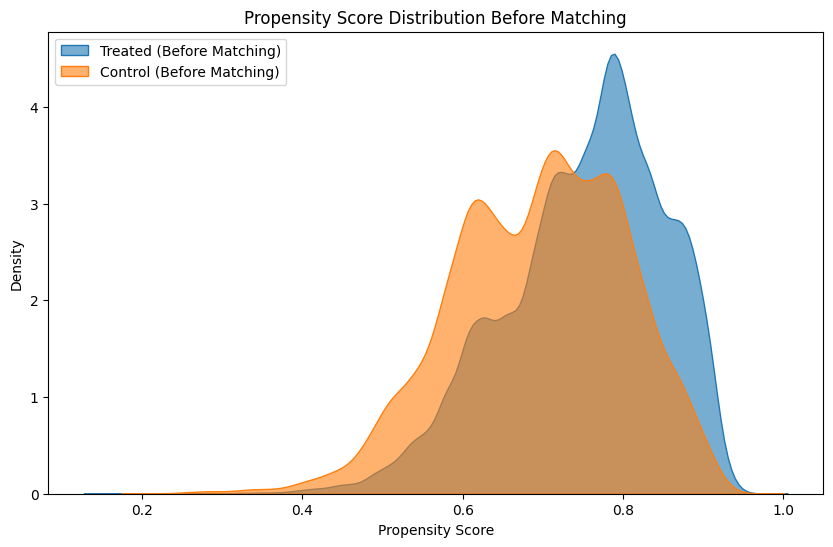

d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



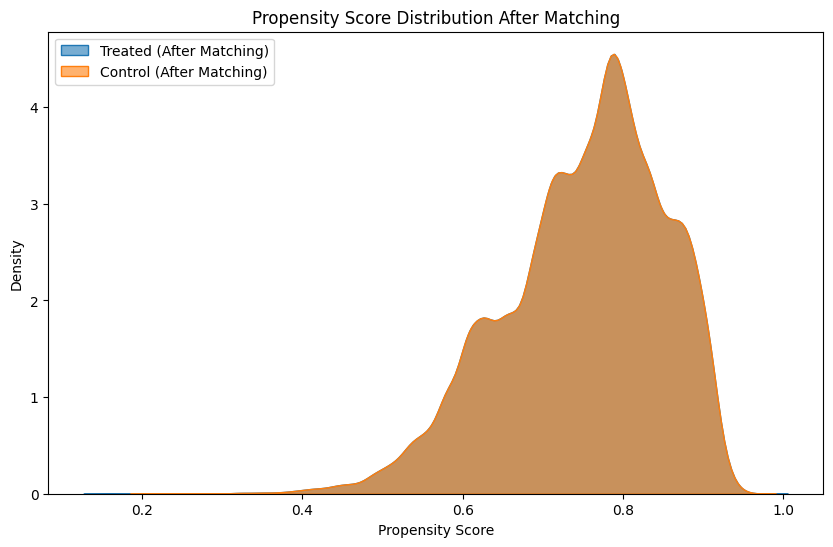

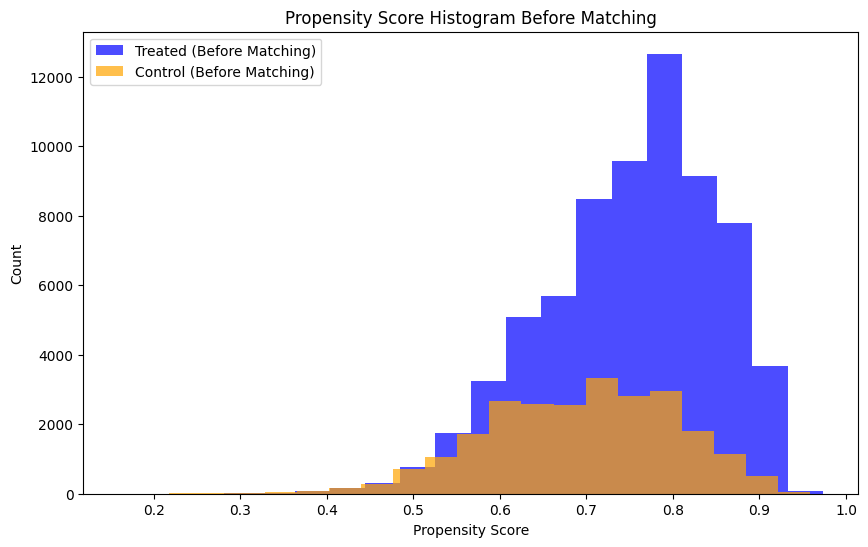

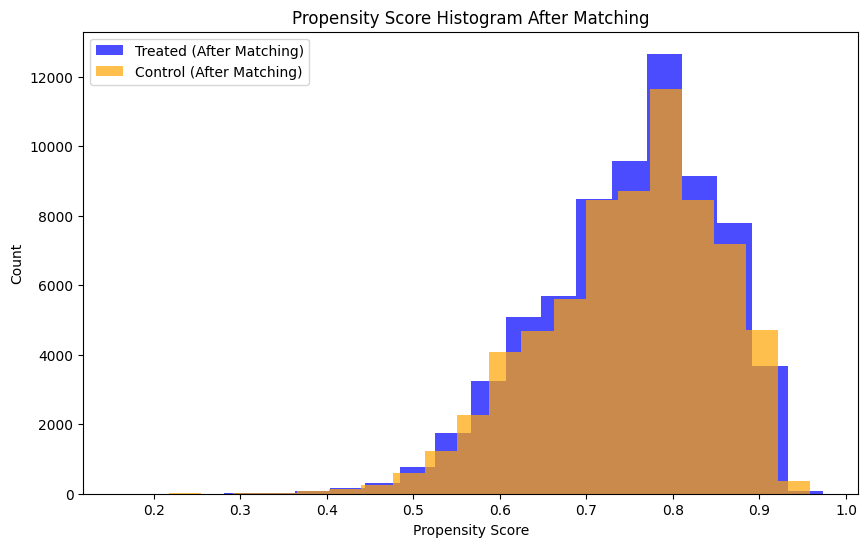

In [6]:

# In[14]:


import matplotlib.pyplot as plt
import seaborn as sns

# Visualization: Density Plot of Propensity Scores
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data[data['day_night'] == 1]['propensity_score'], label='Treated (Before Matching)', fill=True, alpha=0.6)
sns.kdeplot(data=data[data['day_night'] == 0]['propensity_score'], label='Control (Before Matching)', fill=True, alpha=0.6)
plt.title('Propensity Score Distribution Before Matching')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()
plt.show()

# Combine matched treated and control units into a single DataFrame
matched = pd.concat([matched_treated, matched_controls])

# Visualization: After Matching
plt.figure(figsize=(10, 6))
sns.kdeplot(data=matched[matched['day_night'] == 1]['propensity_score'], label='Treated (After Matching)', fill=True, alpha=0.6)
sns.kdeplot(data=matched[matched['day_night'] == 0]['propensity_score'], label='Control (After Matching)', fill=True, alpha=0.6)
plt.title('Propensity Score Distribution After Matching')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()
plt.show()

# Optional: Histogram of Propensity Scores
plt.figure(figsize=(10, 6))
plt.hist(data[data['day_night'] == 1]['propensity_score'], bins=20, alpha=0.7, label='Treated (Before Matching)', color='blue')
plt.hist(data[data['day_night'] == 0]['propensity_score'], bins=20, alpha=0.7, label='Control (Before Matching)', color='orange')
plt.title('Propensity Score Histogram Before Matching')
plt.xlabel('Propensity Score')
plt.ylabel('Count')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(matched[matched['day_night'] == 1]['propensity_score'], bins=20, alpha=0.7, label='Treated (After Matching)', color='blue')
plt.hist(matched[matched['day_night'] == 0]['propensity_score'], bins=20, alpha=0.7, label='Control (After Matching)', color='orange')
plt.title('Propensity Score Histogram After Matching')
plt.xlabel('Propensity Score')
plt.ylabel('Count')
plt.legend()
plt.show()




ATT (IPW): -0.010
Weighted Treated Mean: 0.009
Weighted Control Mean: 0.019
ATT (IPW): -0.010


d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



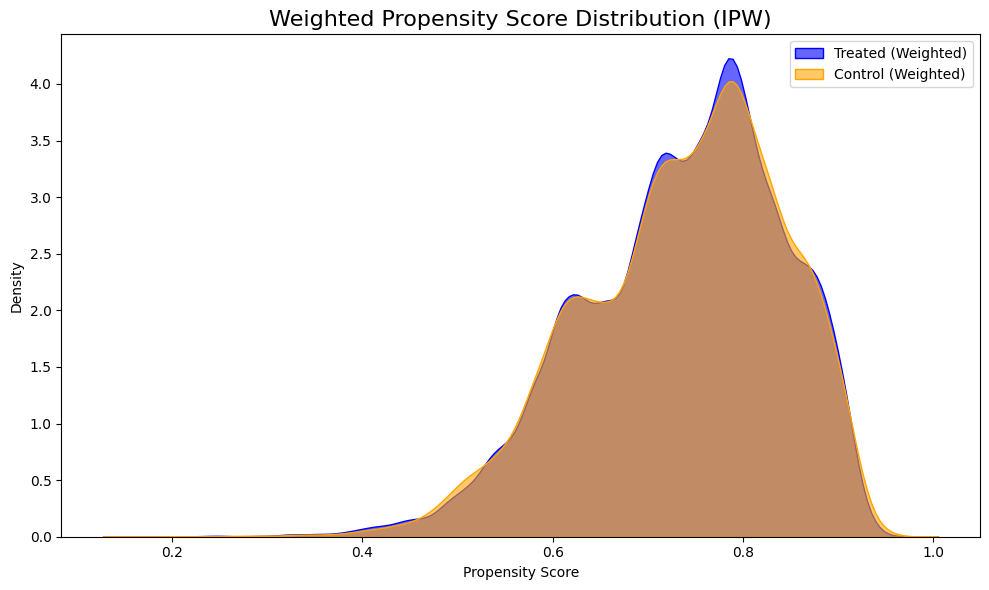

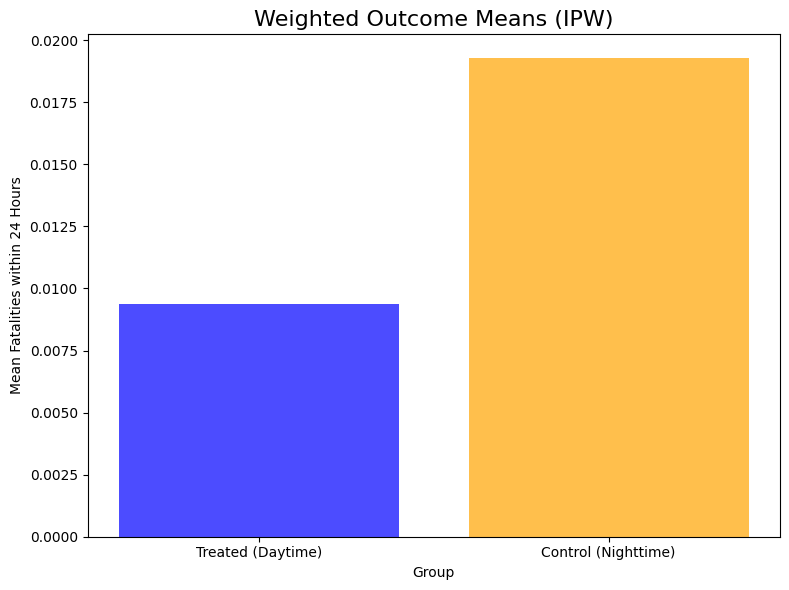

ATT: -0.012


In [7]:
# In[10]:


# Step 2: Calculate IPW weights
data['weight'] = np.where(
    data['day_night'] == 1, 
    1 / data['propensity_score'],  # Treatment group weight
    1 / (1 - data['propensity_score'])  # Control group weight
)

# Step 3: Calculate weighted means for outcome
treated = data[data['day_night'] == 1]
control = data[data['day_night'] == 0]

weighted_treated_mean = np.sum(treated['morti_entro_24_ore'] * treated['weight']) / np.sum(treated['weight'])
weighted_control_mean = np.sum(control['morti_entro_24_ore'] * control['weight']) / np.sum(control['weight'])

# Step 4: Compute ATT
att_ipw = weighted_treated_mean - weighted_control_mean
print(f"ATT (IPW): {att_ipw:.3f}")

import seaborn as sns
import matplotlib.pyplot as plt

# Add weights to the dataset
data['ipw_treated'] = np.where(data['day_night'] == 1, data['weight'], 0)
data['ipw_control'] = np.where(data['day_night'] == 0, data['weight'], 0)

# Print mathematical results
print(f"Weighted Treated Mean: {weighted_treated_mean:.3f}")
print(f"Weighted Control Mean: {weighted_control_mean:.3f}")
print(f"ATT (IPW): {att_ipw:.3f}")

# Density plot of propensity scores (weighted)
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data, x='propensity_score', weights='ipw_treated', label='Treated (Weighted)', fill=True, alpha=0.6, color="blue")
sns.kdeplot(data=data, x='propensity_score', weights='ipw_control', label='Control (Weighted)', fill=True, alpha=0.6, color="orange")
plt.title('Weighted Propensity Score Distribution (IPW)', fontsize=16)
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate weighted means for visualization
weighted_treated_mean = np.sum(treated['morti_entro_24_ore'] * treated['weight']) / np.sum(treated['weight'])
weighted_control_mean = np.sum(control['morti_entro_24_ore'] * control['weight']) / np.sum(control['weight'])

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(['Treated (Daytime)', 'Control (Nighttime)'], 
        [weighted_treated_mean, weighted_control_mean], 
        color=['blue', 'orange'], alpha=0.7)
plt.title('Weighted Outcome Means (IPW)', fontsize=16)
plt.ylabel('Mean Fatalities within 24 Hours')
plt.xlabel('Group')
plt.tight_layout()
plt.show()




# In[11]:


att = matched[matched['day_night'] == 1]['morti_entro_24_ore'].mean() - \
      matched[matched['day_night'] == 0]['morti_entro_24_ore'].mean()
print(f"ATT: {att:.3f}")


# In[ ]:



Standardized Mean Differences (Before Matching):
{'provincia_10': 0.0640450888908935, 'provincia_12': 0.013152253064005531, 'provincia_15': -0.04387235967428967, 'provincia_16': -0.00936126787705601, 'provincia_17': 0.0030264816660406577, 'provincia_21': 0.0736274680005735, 'provincia_23': 0.014501035180117841, 'provincia_24': 0.018546804783253566, 'provincia_26': 0.02400324988533333, 'provincia_27': 0.0258212908315963, 'provincia_28': 0.02111022443703546, 'provincia_35': 0.03770853261124392, 'provincia_36': 0.042081885237349556, 'provincia_37': 0.04737368766784013, 'provincia_39': 0.0030333659450790308, 'provincia_48': 0.07235930156585098, 'provincia_58': -0.06079181141652446, 'provincia_59': 0.011317208278312793, 'provincia_63': -0.05079985672249713, 'provincia_65': -0.04876001669090894, 'provincia_72': -0.02425309264545655, 'provincia_82': -0.042049332154680395, 'provincia_87': -0.062037772134350064, 'provincia_108': -0.0005763847410764221, 'tipo_di_strada_2': 0.07091160114043735, '

d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

d:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



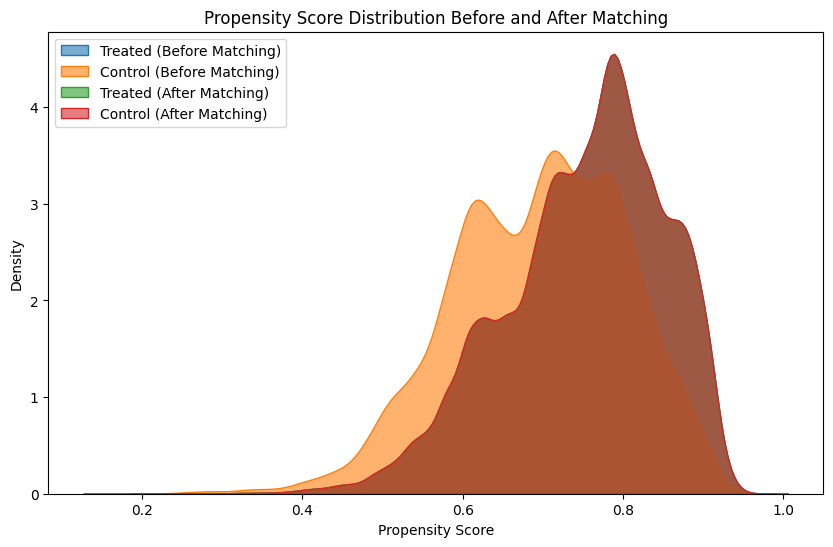

In [8]:
import seaborn as sns
from sklearn.metrics import pairwise_distances

import matplotlib.pyplot as plt

# Covariate Balance Check
def calculate_smd(df, treatment_col, covariates):
    treated = df[df[treatment_col] == 1]
    control = df[df[treatment_col] == 0]
    smd = {}
    for covariate in covariates:
        mean_treated = treated[covariate].mean()
        mean_control = control[covariate].mean()
        std_treated = treated[covariate].std()
        std_control = control[covariate].std()
        smd[covariate] = (mean_treated - mean_control) / ((std_treated**2 + std_control**2) / 2)**0.5
    return smd

covariates = X.columns.tolist()
if 'const' in covariates:
    covariates.remove('const')
smd_before = calculate_smd(data, 'day_night', covariates)
smd_after = calculate_smd(matched, 'day_night', covariates)

print("Standardized Mean Differences (Before Matching):")
print(smd_before)
print("\nStandardized Mean Differences (After Matching):")
print(smd_after)

# Propensity Score Distribution
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data[data['day_night'] == 1]['propensity_score'], label='Treated (Before Matching)', fill=True, alpha=0.6)
sns.kdeplot(data=data[data['day_night'] == 0]['propensity_score'], label='Control (Before Matching)', fill=True, alpha=0.6)
sns.kdeplot(data=matched[matched['day_night'] == 1]['propensity_score'], label='Treated (After Matching)', fill=True, alpha=0.6)
sns.kdeplot(data=matched[matched['day_night'] == 0]['propensity_score'], label='Control (After Matching)', fill=True, alpha=0.6)
plt.title('Propensity Score Distribution Before and After Matching')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()
plt.show()

In [11]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import pandas as pd
import plotly.express as px

# Initialize the Dash app
app = dash.Dash(__name__)
app.title = "Propensity Score Analysis Dashboard"

# Layout of the dashboard
app.layout = html.Div([
    html.H1("Propensity Score Analysis Dashboard", style={'text-align': 'center', 'color': '#003366'}),
    
    dcc.Tabs([
        dcc.Tab(label='Propensity Score Distribution', children=[
            html.Div([
                dcc.Graph(id='propensity-score-distribution'),
                html.P("This plot shows the distribution of propensity scores before and after matching.", style={'text-align': 'center'})
            ], style={'padding': '20px'})
        ]),
        dcc.Tab(label='Covariate Balance', children=[
            html.Div([
                dcc.Graph(id='covariate-balance'),
                html.P("This plot shows the standardized mean differences of covariates before and after matching.", style={'text-align': 'center'})
            ], style={'padding': '20px'})
        ]),
        dcc.Tab(label='Outcome Analysis', children=[
            html.Div([
                dcc.Graph(id='outcome-analysis'),
                html.P("This plot shows the weighted mean fatalities within 24 hours for treated and control groups.", style={'text-align': 'center'})
            ], style={'padding': '20px'})
        ]),
    ], style={'font-family': 'Arial', 'font-size': '18px'})
], style={'background-color': '#f9f9f9', 'padding': '20px'})

# Callback to update the propensity score distribution plot
@app.callback(
    Output('propensity-score-distribution', 'figure'),
    Input('propensity-score-distribution', 'id')
)
def update_propensity_score_distribution(_):
    fig = px.histogram(data, x='propensity_score', color='day_night',
                       title='Propensity Score Distribution',
                       labels={'propensity_score': 'Propensity Score', 'day_night': 'Day/Night'},
                       barmode='overlay', histnorm='density')
    fig.update_layout(bargap=0.2, template='plotly_white')
    return fig

# Callback to update the covariate balance plot
@app.callback(
    Output('covariate-balance', 'figure'),
    Input('covariate-balance', 'id')
)
def update_covariate_balance(_):
    smd_df = pd.DataFrame({
        'Covariate': list(smd_before.keys()),
        'SMD Before': list(smd_before.values()),
        'SMD After': list(smd_after.values())
    })
    fig = px.bar(smd_df, x='Covariate', y=['SMD Before', 'SMD After'],
                 title='Covariate Balance Before and After Matching',
                 labels={'value': 'Standardized Mean Difference', 'variable': 'Matching Status'},
                 barmode='group')
    fig.update_layout(bargap=0.2, template='plotly_white')
    return fig

# Callback to update the outcome analysis plot
@app.callback(
    Output('outcome-analysis', 'figure'),
    Input('outcome-analysis', 'id')
)
def update_outcome_analysis(_):
    outcome_df = pd.DataFrame({
        'Group': ['Treated (Daytime)', 'Control (Nighttime)'],
        'Weighted Mean Fatalities': [weighted_treated_mean, weighted_control_mean]
    })
    fig = px.bar(outcome_df, x='Group', y='Weighted Mean Fatalities',
                 title='Weighted Outcome Means (IPW)',
                 labels={'Weighted Mean Fatalities': 'Mean Fatalities within 24 Hours'},
                 color='Group', color_discrete_map={'Treated (Daytime)': 'blue', 'Control (Nighttime)': 'orange'})
    fig.update_layout(bargap=0.2, template='plotly_white')
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)